# Create a deconvolved stellar template

Before modelling observations of the star to extract RVs, we need to create a high-S/N stellar template


What you need:

- observation spectra of hot stars, which do not show any spectral features in the I2 wavelength range between ~ 5000 -- 6000 Å, obtained *with* the I2 cell in the light path; the recorded spectra then basically only consist of the I2 features, and can be used to determine the LSF of the instrument. 

- observation spectra of the star of interest *without* any I2 absorption features;

First, we need to set up the path and import the required pyodine modules:

In [1]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt

sys.path.append('/home/paul/pyodine/')

import pyodine
import pyodine_create_templates

Also, we import the utilities module for the instrument we are working with - in this case for SONG. It contains all the instrument-specific code, particularly routines to import the spectra from fits along with useful information from the fits headers. Upon import we call the SONG-specific ``utilities_song`` simply ``utilities``:

In [2]:
import utilities_song as utilities

Additionally, a parameter input object of type ``Template_Parameters`` is needed. That one contains all the instruments-specific parameters such as oversampling used, how to chunk up the spectrum, and also the exact definition of the workflow for the analysis routine. By default, there should be a module called ``pyodine_parameters`` within each ``utilities`` module, but you could also create a different one and import it if you wish to experiment with changing parameters. However, we will stick with the well-tested default parameters here:

In [3]:
Pars = utilities.pyodine_parameters.Template_Parameters()

Finally, we need to define the pathnames to the observations of the O-star with I2, and to the observations of the star without I2. We simply collect them from the respective directories of the tutorial data. Also, we define the output pathname for the deconvolved template, the pathname for a directory where to save analysis plots, and the output pathnames of the collected results. In our analysis, we model the O-star data in two runs (first with a Single-Gaussian LSF to establish good parameter guesses, and then with the final Multi-Gaussian LSF), and we save the results from both runs - the first as '.h5' (HDF5 format), the second as '.pkl' (through the **dill** Python package).

In [9]:
# O-star observations to use for the modelling
ostar_dir = '/home/paul/data_song/data_ext/sigdra_template/2018-05-16/obs_ostar'
ostar_files = [os.path.join(ostar_dir, f) for f in os.listdir(ostar_dir)]
ostar_files.sort()

# Stellar observations to use for the deconvolution
temp_dir = '/home/paul/data_song/data_ext/sigdra_template/2018-05-16/obs_temp'
temp_files = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir)]
temp_files.sort()

# Output pathname for the template
temp_outname = '/home/paul/data_song2/templates/temp_sigdra_2018-05-16.h5'

# Output directory for plots and pathnames for modelling results
plot_dir = '/home/paul/data_song2/data_res/sigdra/'
res_files = ['/home/paul/data_song2/data_res/sigdra/sigdra_res0.h5',
             '/home/paul/data_song2/data_res/sigdra/sigdra_res1.pkl']

And now, we can kick off the template creation:

In [7]:
pyodine_create_templates.create_template(utilities, Pars, ostar_files, temp_files, temp_outname, 
                    plot_dir=plot_dir, res_files=res_files)

Orders to use:  [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Velocity guess: 25.136 km/s
Barycentric velocity: 2.026 km/s
Warning! Max. nr. of chunks without cutting down is 21!

Total number of chunks:  528
Chunks per order:  22
First and last covered pixel of chunks: 30, 2031
Orders:  18  -  41


----------------------
RUN 0
----------------------


100% (528 of 528) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


Number of chunks with no uncertainties:  0
Number of chunks with outliers:  0
Number of chunks with nan fitted red. Chi2:  0
Creating analysis plots...

----------------------
RUN 1
----------------------
Fitted LSF parameters:
 <ParameterSet (values: 10)>
    left_1  =  6.491226501145553
    left_2  =  -8.060503954209725
    left_3  =  4.2641949580532925
    left_4  =  -1.4996989286612574
    left_5  =  0.37808604131223594
    right1  =  6.491312875599473
    right2  =  -8.060599340542252
    right3  =  4.264240048195785
    right4  =  -1.499713032073036
    right5  =  0.3780894175194895


100% (528 of 528) |######################| Elapsed Time: 0:01:25 Time:  0:01:25


Number of chunks with no uncertainties:  0
Number of chunks with outliers:  0
Number of chunks with nan fitted red. Chi2:  0
The extension .dill does not match the filetype dill.
It should be one of:  ('.pkl',)
Correcting it to: .pkl
Creating analysis plots...

----------------------
All runs done, continuing to template deconvolution...

Deconvolving chunks...


100% (528 of 528) |######################| Elapsed Time: 0:01:55 Time:  0:01:55



Done, full working time:  254.0637001991272


Great, everything went fine!

Open the saved results file and inspect it

In [31]:
fit_results_1 = pyodine.fitters.results_io.load_results(res_files[1], filetype='dill')

chunks = pyodine.components.ChunkArray()
for r in fit_results_1:
    chunks.append(r.chunk)

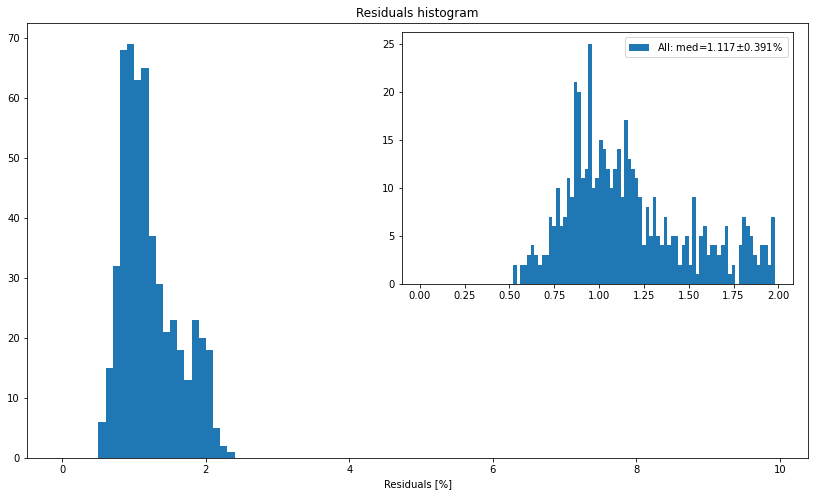

In [32]:
residuals = pyodine.plot_lib.plot_residual_hist(fit_results_1, title='Residuals histogram', show_plot=True)

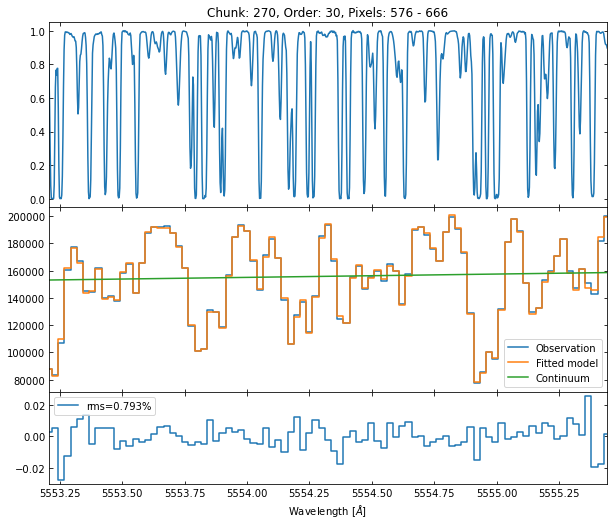

In [33]:
pyodine.plot_lib.plot_chunkmodel(fit_results_1, chunks, 270, template=False, show_plot=True)

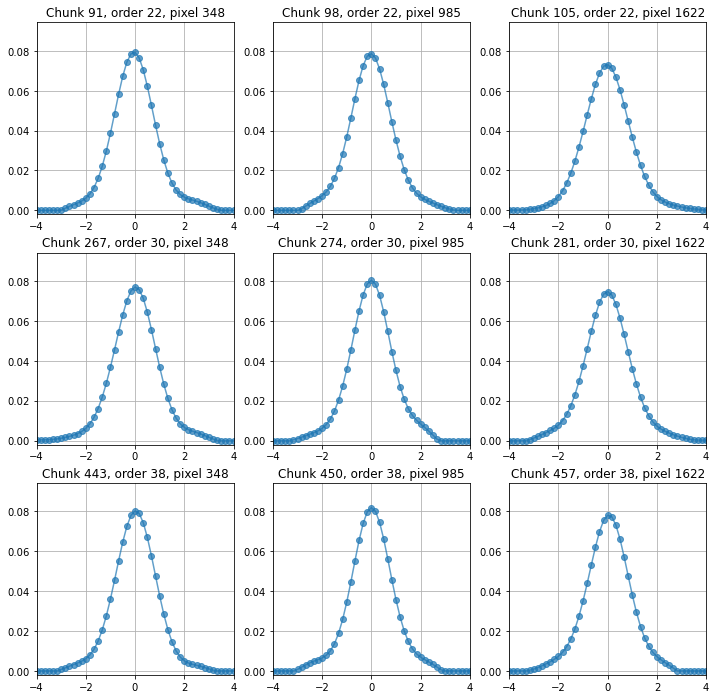

In [61]:
lsf_model = fit_results_1[0].model.lsf_model
lsf_x = lsf_model.generate_x(6, conv_width=6.)

lsfs = []
for i in range(len(fit_results_1)):
    lsf_pars = fit_results_1[i].params.filter('lsf')
    lsfs.append(lsf_model.eval(lsf_x, lsf_pars))

pyodine.plot_lib.plot_lsfs_grid(lsfs, chunks, x_lsf=lsf_x, x_nr=3, y_nr=3, alpha=0.7, xlim=(-4,4), show_plot=True)

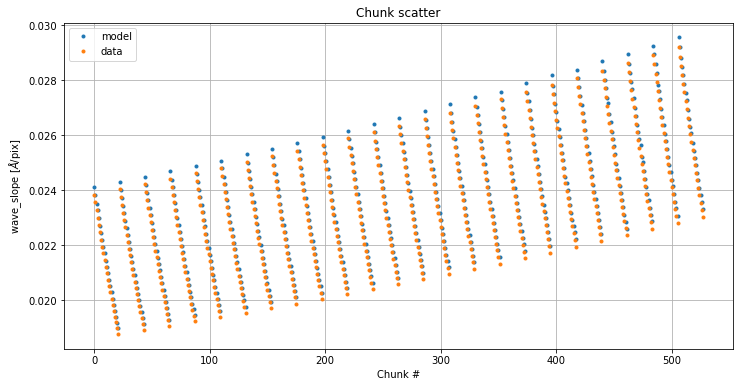

In [75]:
wave_slopes_model = [r.params['wave_slope'] for r in fit_results_1]
wave_slopes_data = [(ch.wave[-1]-ch.wave[0])/len(ch) for ch in chunks]

pyodine.plot_lib.plot_chunk_scatter(scatter=[wave_slopes_model,wave_slopes_data], 
                                    scatter_fmt='.', scatter_label=['model', 'data'], 
                                    ylabel=r'wave_slope [$\AA$/pix]', show_plot=True)

In [85]:
import recover_obs_result

chunks, fit_results_0 = recover_obs_result.recover_obs_results(res_files[0])

Warning! Max. nr. of chunks without cutting down is 21!
30
Total number of created chunks: 528 (in result file: 528)
Number of created chunks per order: 22
<ParameterSet (values: 8)>
    cont_intercept  =  34264.84865543534
    cont_slope      =  59.16037013167056
    iod_depth       =  0.9118854140584899
    lsf_fwhm        =  1.7504541232372794
    tem_depth       =  1.0
    velocity        =  0.0
    wave_intercept  =  4995.288846059235
    wave_slope      =  0.024104910295125084


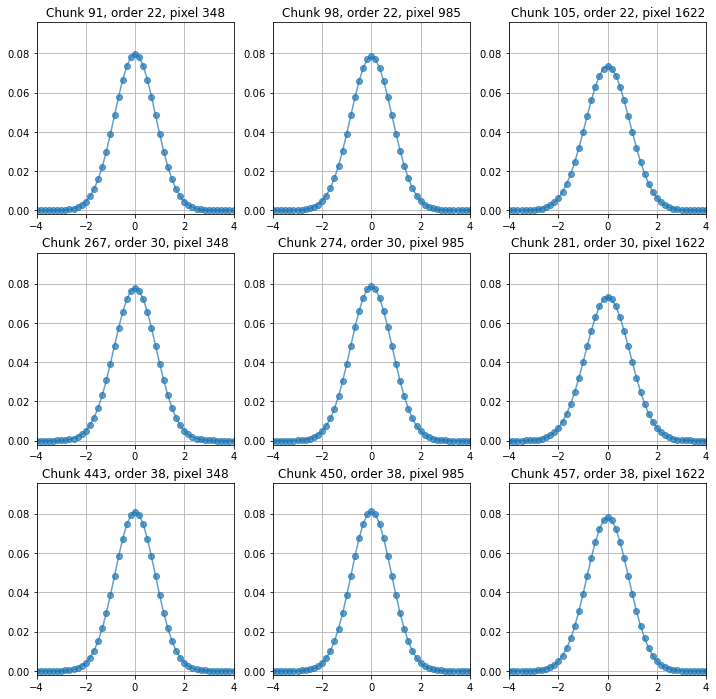

In [88]:
lsf_model = fit_results_0[0].model.lsf_model
lsf_x = lsf_model.generate_x(6, conv_width=6.)

lsfs = []
for i in range(len(fit_results_0)):
    lsf_pars = fit_results_0[i].params.filter('lsf')
    lsfs.append(lsf_model.eval(lsf_x, lsf_pars))

pyodine.plot_lib.plot_lsfs_grid(lsfs, chunks, x_lsf=lsf_x, x_nr=3, y_nr=3, alpha=0.7, xlim=(-4,4), show_plot=True)